# L08-2 HW for Introduction to Classification
## Assignment Instructions

Rename with your name in place of Studentname and make your edits and updates here. Run each cell one at a time to make sure you understand what the code is doing.

You'll find 3 <font color="blue">Your Turn</font> prompts for exercises and questions to complete in this homework.


# Introduction to Classification

## Overview

**Classification** is one of the most widely used machine learning methods. Classifiers divide cases into specific **classes**. Broadly, there are two types of classifiers:
- **Two-class** or **binary**, where cases are placed into one of two classes, often labeled $\{positive\, negative\}$ or $\{1, 0\}$.
- **Multi-class** where cases are placed into three or more classes. 

Classifiers are so widely used because they are so useful. Some of the applications of classifiers include:

- Identify customers most likely to churn to a competitor
- Spot fraudulent payment accounts
- Identify students most likely to fail a course
- Find machinery in need of maintenance
- Find relevant documents
- Identify handwritten characters
- Identify patients with a disease

Once you have completed this lesson you will be able to apply logistic regression to two class classification. Specifically, in this lesson you will explore:

- **Basics of classifiers** using logistic regression as an example.
- **Train a simple classifier** using a single feature.
- **Update the model** so it is not over-fit.
- **Evaluation of classifier** using the two-class classification example.
- **Construct and evaluate** a classifier for a real-world example.

***
**Required packages** to run this notebook are:
- HistData
- ggplot2
- tidyverse
- caret
- car
***

## Basics of Classifiers

Classifiers are a **supervised machine learning** method. By supervised, we mean that the classifier is **trained** using know **label values**. The label is a column in each training case which contains the known value we want our algorithm to learn to predict.   

A classifier is trained to predict the label using one or more **features**. Features are variables which provide information on which class a label is in. The predicted class or category is known as the **score**. 

Once a classifier model is trained, predictions of unknown labels can be made from new cases (sets of feature values). In production we, want our model to reliably create accurate predictions for cases the model has not seen. We say that a model with this behavior **generalizes** well. 


### Overview of logistic regression

Let's look at a specific example of a binary classifier. The **logistic regression** model is a linear model. Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`.  However, the response is computed as a log likelihood. In the simplest case, the response has a Binomial distribution. 

The response of the linear model is transformed to the log likelihood using a sigmoidal function, also known as the **logistic function**:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

Loading required package: ggplot2


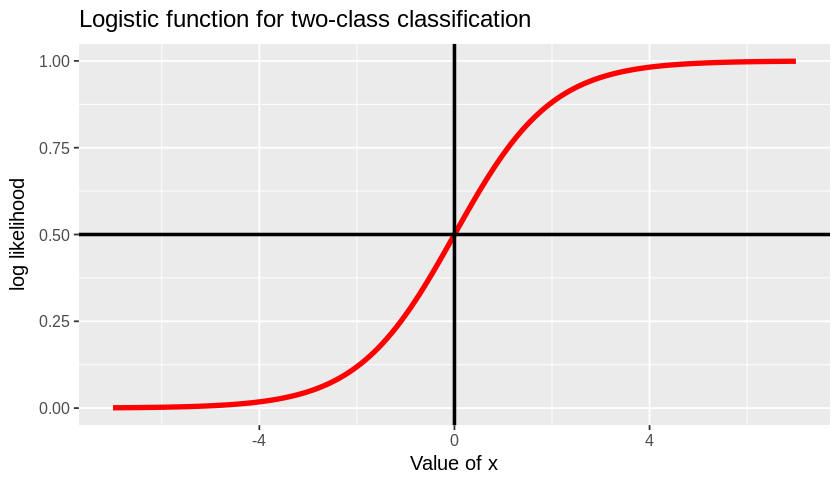

In [1]:
options(repr.pmales.extlot.width=6, repr.plot.height=4)

xseq = seq(-7, 7, length.out = 500)
plot.logistic = function(v){
  require(ggplot2)
  logistic = exp(xseq - v)/(1 + exp(xseq - v))
  df = data.frame(x = xseq, y = logistic)
  ggplot(df, aes(x,y)) +
    geom_line(size = 1.5, color = 'red') +
    geom_vline(xintercept = v, size = 1, color = 'black') +
    geom_hline(yintercept = 0.5, size = 1, color = 'black') +
    ylab('log likelihood') + xlab('Value of x') +
    ggtitle('Logistic function for two-class classification') +
    theme_grey(base_size = 12)
}
plot.logistic(0)

Let's make this a bit more concrete with a simple example. Say we have a linear model for a single feature $x$:

$$\hat{y} = \beta_0 + \beta_1\ x\\
where\\
\beta_0 = intercept\ coefficient\\
\beta_1 = slope\ coefficient$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continuous output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$

### Classification Example

The Galton Family data in the R HistData package are famous in the history of statistics. Francis Galton (1822-1911) used these data in the 1886 paper where he introduced the concept of regression. We will use these data for another purpose. We will use these data to classify the gender of adult children using their heights.
In this example, we will use a single feature, height of the adult children. The label is the gender of the adult child. We will logistic regression to classify the label using the one feature, making a simple classification problem.

As a first step, execute the code in the cell below to load and examine these data.


In [2]:
set.seed(3456)  ## Ensure the examples are reproducible. 
require(HistData) ## HistData package has the GaltonFamilies data.
require(ggplot2)
require(tidyverse)
glimpse(GaltonFamilies)   

Loading required package: HistData
Loading required package: tidyverse
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


Observations: 934
Variables: 8
$ family          <fctr> 001, 001, 001, 001, 002, 002, 002, 002, 003, 003, ...
$ father          <dbl> 78.5, 78.5, 78.5, 78.5, 75.5, 75.5, 75.5, 75.5, 75....
$ mother          <dbl> 67.0, 67.0, 67.0, 67.0, 66.5, 66.5, 66.5, 66.5, 64....
$ midparentHeight <dbl> 75.43, 75.43, 75.43, 75.43, 73.66, 73.66, 73.66, 73...
$ children        <int> 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 6, 6, ...
$ childNum        <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 2, 3, 4, 5, 1, 2, ...
$ gender          <fctr> male, female, female, female, male, male, female, ...
$ childHeight     <dbl> 73.2, 69.2, 69.0, 69.0, 73.5, 72.5, 65.5, 65.5, 71....


The last two columns in this data frame contain the label and the feature we will use.

Next, let's see how the values of the feature relate to the value of the label. The ideal feature should have values that **separate** the categories of the label. By separate, we mean the feature has a distinct range of values for each label category. Any overlap in the range of values of a feature for different label categories will likely result in **classification errors**.  

### Exploring and preparing the data
In order to examine the degree of separation achieved by the one feature we will create side by side violin plots. Execute this code, and examine the results. 

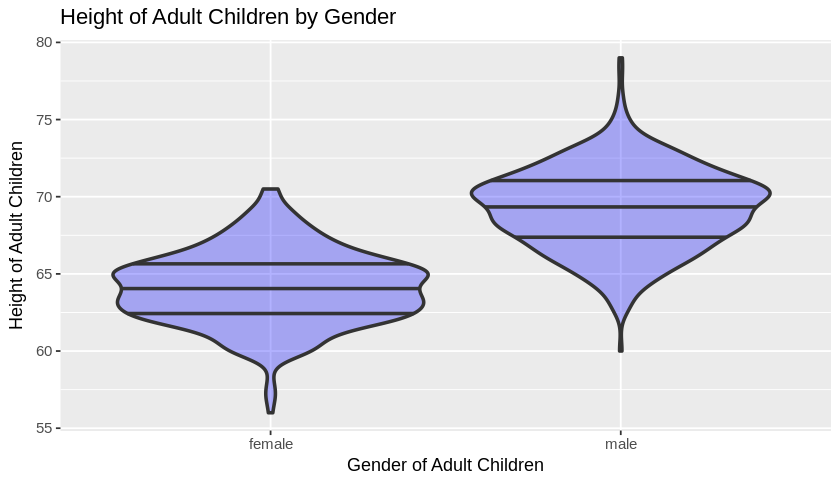

In [3]:
ggplot(GaltonFamilies, aes(gender, childHeight)) +
       geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), 
                   fill = 'blue', alpha = 0.3, size = 1.0) +
       ylab('Height of Adult Children') +
       xlab('Gender of Adult Children') +
       ggtitle('Height of Adult Children by Gender')

This feature separates the cases fairly well. Notice that the overlap of heights by gender are in the upper quartile of `female` and lower quartile of `male`. The bulk of feature values for each category do not overlap. Thus, we expect our linear classifier to work fairly well. 

These data look promising, and there does not seem to be any serious problems. Let's move on to constructing a classification model. The first step in building any machine learning model is to normalize the numeric features. In this case, there is only one feature, but in the interest of the lesson, we will normalize anyway.  Execute the code in the cell below to scale the feature. 

In [4]:
require(tidyverse)
normalize = function(x) (x - mean(x))/sd(x)
GaltonFamilies = GaltonFamilies %>% 
                    mutate(childHeightScaled = normalize(childHeight)) 

### Training the classifier

With the data prepared, it is time to train the classifier. In this case, we will use the R **generalized linear model or glm**. We want to model the two-class or **binomial** relationship between the label and the feature as:

$$gender \sim childHeightScaled$$

We pick the binomial family, since we are preforming two-class classification. 

The generalized linear model reports some fit statistics in terms of **deviance**. Deviance is a hard to grasp concept, so we will skip the formal mathematical definition. Rather, let's establish an intuitive understanding of what deviance means. Deviance is the difference in log likelihood of a model with respect to a **saturated model**. The saturated or reference model has a coefficient for each data point. We can compare deviance values to evaluate the fit of the model. Specifically, we can define the deviance:

$$D_{model} = 2 \Bigg( log \Big( \frac{likelihood\ of\ model}{likelihood\ of\ staturated\ model} \Big) \Bigg)\\
and\\
D_{Null} = 2 \Bigg( log \Big( \frac{likelihood\ of\ Null\ model}{likelihood\ of\ staturated\ model} \Big) \Bigg)
$$

Where:

- $D_{model}$ is the **deviance** of the **model**. 
- $D_{Null}$ is the **deviance** of the **Null**. 
- A **Null model** has only an intercept. In other words, the null model is just the average of the features. 
- A **Saturated model** has the number of coefficients equal to the number of cases. Such a model is drastically over-fit, and therefore not useful for predictions. 

We compare the deviance of the model being evaluated to the deviance of a model that just uses the average value of the label. The larger this difference the better the variation in the label is explained by the model. 

Another metric which can be hard to grasp is the **Akaike information criterion (AIC)**. The AIC is based on concepts from information theory. The basic idea is to measure of the **likelihood** of the model, given the data, but adjusted for the **complexity of the model**. We can write AIC as:

$$AIC = 2 k - 2 log(likelihood\ of\ model)\\
where\\
k = number\ of\ model\ parameters$$

In other words, AIC is the log likelihood of the model penalized for complexity. The smaller the AIC the greater the likelihood of the model. Complex models with larger numbers of parameters have larger AIC. 

The `summary` method for the model contains the following:  

- The call used to compute the model being evaluate, which includes the model formula, the choice of distribution family, and the data frame used.
- Quartiles, minimum and maximum value of the residuals. 
- Table of model coefficients, one for each feature in the model, plus the intercept if included. The figures in this table are used to determine if the coefficients are significant. Models with coefficients which are not significant are overfit. Each coefficient has the following statistics which are used to determine if coefficients are significant:
  - The coefficient values themselves.
  - The standard error of each model coefficient. If the standard error is of the same magnitude (or larger) than the coefficient value, the coefficient is not significant. 
  - Statistics for the hypothesis test on the model.
- The Null deviance of the model.
- Residual deviance of the model. We compare this value to the deviance of a Null model. The better the fit of the model, the greater the explanatory power of the model. 
- AIC of the model. The smaller the AIC the more information the model provides. 

Execute the code in the cell below which trains this model and prints a summary and the **confidence intervals** of the model coefficients. 

In [5]:
height.mod = glm(gender ~ childHeightScaled, data = GaltonFamilies, 
                family=binomial())
summary(height.mod)
cat('Confidence intervals of coefficients')
confint(height.mod)


Call:
glm(formula = gender ~ childHeightScaled, family = binomial(), 
    data = GaltonFamilies)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5473  -0.5022   0.0700   0.5034   3.2310  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.1947     0.1003    1.94   0.0523 .  
childHeightScaled   2.8698     0.1806   15.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1293.96  on 933  degrees of freedom
Residual deviance:  647.15  on 932  degrees of freedom
AIC: 651.15

Number of Fisher Scoring iterations: 6


Confidence intervals of coefficients

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-0.0008831065,0.3930603
childHeightScaled,2.5315173516,3.2405677


Notice the following about the fit of this model:

1. You can see that this model is over fit. The intercept term is not significant since the standard error is nearly as large as the coefficient value, the z-value is small, the p-value is large. Further, the confidence interval spans 0.
2. The Null deviance is significantly larger than the residual deviance indicating the model has explanatory power. 
3. The AIC and deviance statistics will be used to compare this model to other possible models.

****
# <font color="blue">Your turn</font>   

The above model is clearly overfit. You will now update this model by removing the intercept. In the R formula language a `-1` in the formula removes the intercept. The updated formula to model `gender` by the child height without the intercept becomes:

$$gender \sim childHeightScaled - 1$$

**Hints:** To ensure the rest of this notebook behaves correctly it is important you make a **copy of the data frame** and assign the model to a **new name**.
***

In [6]:
GaltonFamilies2 = GaltonFamilies # copy of df
glimpse(GaltonFamilies2)
# new model name
height.mod2 = glm(gender ~ childHeightScaled - 1, data = GaltonFamilies2, 
                family=binomial())
summary(height.mod2)
cat('Confidence intervals of coefficients')
confint(height.mod2)

Observations: 934
Variables: 9
$ family            <fctr> 001, 001, 001, 001, 002, 002, 002, 002, 003, 003...
$ father            <dbl> 78.5, 78.5, 78.5, 78.5, 75.5, 75.5, 75.5, 75.5, 7...
$ mother            <dbl> 67.0, 67.0, 67.0, 67.0, 66.5, 66.5, 66.5, 66.5, 6...
$ midparentHeight   <dbl> 75.43, 75.43, 75.43, 75.43, 73.66, 73.66, 73.66, ...
$ children          <int> 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 6, 6...
$ childNum          <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 2, 3, 4, 5, 1, 2...
$ gender            <fctr> male, female, female, female, male, male, female...
$ childHeight       <dbl> 73.2, 69.2, 69.0, 69.0, 73.5, 72.5, 65.5, 65.5, 7...
$ childHeightScaled <dbl> 1.80318959, 0.68563741, 0.62975980, 0.62975980, 1...



Call:
glm(formula = gender ~ childHeightScaled - 1, family = binomial(), 
    data = GaltonFamilies2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4598  -0.4636   0.0797   0.5566   3.2716  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
childHeightScaled   2.8370     0.1775   15.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1294.80  on 934  degrees of freedom
Residual deviance:  650.95  on 933  degrees of freedom
AIC: 652.95

Number of Fisher Scoring iterations: 6


Confidence intervals of coefficients

Waiting for profiling to be done...


2.5 %   97.5 % 
2.504180 3.201028

<div style="background-color: ivory">
<h3>Questions</h3>
<p>Answer the following questions about the fit of the new model.</p>
<ol>
<li>Is the single model coefficient significance based on t-statistic and p-value?</li>
<li>Does the confidence interval overlap 0 or not?</li>
<li>Have the Null or Residual deviance changed significantly?</li>
<li>Is the AIC higher, lower, or the same?</li>
<li>Overall does the simplified model appear to be a good fit?</li>
</ol>
</div>

### Answers
1. Yes, model coefficient is significant. p<0.001 and large z value.

2. No, does not overlap 0.

3. Null and Residual deviance are nearly the same.

4. AIC is nearly the same.

5. Yes, the simplified model does not seem to be over-fit. The Null deviance is significantly larger than the residual deviance indicating the model has explanatory power.

The new model does not seem to be over-fit. Notice that the one coefficient is significant. Further the Residual deviance and AIC are nearly the same as the over-fit model.

### Scoring the model

The code in the cell below computes the scores (predicted values) of the label and prints a view of the data frame. Execute this code and examine the results.

In [7]:
GaltonFamilies = GaltonFamilies %>% 
                    mutate(score = predict(height.mod)) 
glimpse(GaltonFamilies)

Observations: 934
Variables: 10
$ family            <fctr> 001, 001, 001, 001, 002, 002, 002, 002, 003, 003...
$ father            <dbl> 78.5, 78.5, 78.5, 78.5, 75.5, 75.5, 75.5, 75.5, 7...
$ mother            <dbl> 67.0, 67.0, 67.0, 67.0, 66.5, 66.5, 66.5, 66.5, 6...
$ midparentHeight   <dbl> 75.43, 75.43, 75.43, 75.43, 73.66, 73.66, 73.66, ...
$ children          <int> 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 6, 6...
$ childNum          <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 2, 3, 4, 5, 1, 2...
$ gender            <fctr> male, female, female, female, male, male, female...
$ childHeight       <dbl> 73.2, 69.2, 69.0, 69.0, 73.5, 72.5, 65.5, 65.5, 7...
$ childHeightScaled <dbl> 1.80318959, 0.68563741, 0.62975980, 0.62975980, 1...
$ score             <dbl> 5.369574550, 2.162375162, 2.002015192, 2.00201519...


Let's plot these score values stratified by the known label categories. Execute the code in the cell below and examine the resulting plots. 

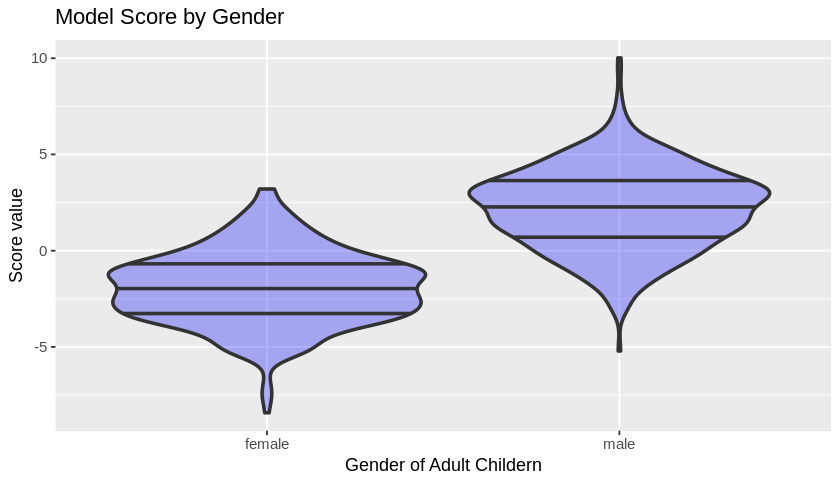

In [8]:
ggplot(GaltonFamilies, aes(gender, score)) +
       geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), 
                   fill = 'blue', alpha = 0.3, size = 1.0) +
       ylab('Score value') +
       xlab('Gender of Adult Childern') +
       ggtitle('Model Score by Gender')

The scores appear to separate the two categories of the label fairly well. As with the feature, the overlap is in the upper quartile of `female` and lower quartile of `male`. 

The scores we have been working with are the raw values computed with the binomial glm model. We need to convert these raw scores to log likelihoods. To do so, we will apply the logistic transformation to the raw scores. The simple logistic transformation is defined as follows:


$$f(x) = \frac{1}{1 + e^{-(x - x_0)}}$$

The code in the cell below applies the logistic transformation and then creates violin plots stratified by the known categories of the label. Execute this code and examine the results.

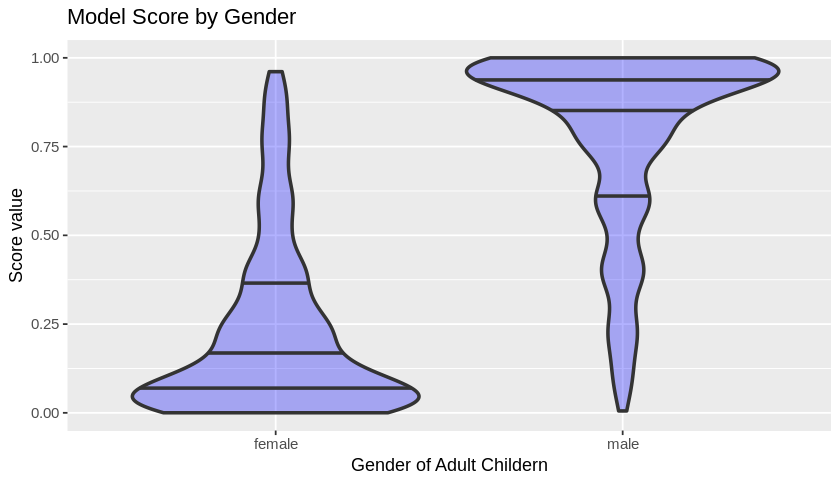

In [9]:
GaltonFamilies = GaltonFamilies %>% 
                    mutate(score.gender = exp(score)/(1 + exp(score))) 
ggplot(GaltonFamilies, aes(gender, score.gender)) +
       geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), 
                   fill = 'blue', alpha = 0.3, size = 1.0) +
       ylab('Score value') +
       xlab('Gender of Adult Childern') +
       ggtitle('Model Score by Gender')

The separation of the two categories of the label is even more clear following the logistic transformation. 

As a next step we will transform the numeric score to a category of `male` and `female`. In this case, we will set the threshold at `0.5`, which gives equal weight to each category. Execute the code in the cell below and review the results. 

In [10]:
GaltonFamilies = GaltonFamilies %>% 
                    mutate(score.gender = ifelse(score.gender > 0.5, 'male', 'female')) 
glimpse(GaltonFamilies)
table(GaltonFamilies$score.gender)

Observations: 934
Variables: 11
$ family            <fctr> 001, 001, 001, 001, 002, 002, 002, 002, 003, 003...
$ father            <dbl> 78.5, 78.5, 78.5, 78.5, 75.5, 75.5, 75.5, 75.5, 7...
$ mother            <dbl> 67.0, 67.0, 67.0, 67.0, 66.5, 66.5, 66.5, 66.5, 6...
$ midparentHeight   <dbl> 75.43, 75.43, 75.43, 75.43, 73.66, 73.66, 73.66, ...
$ children          <int> 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 6, 6...
$ childNum          <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 2, 3, 4, 5, 1, 2...
$ gender            <fctr> male, female, female, female, male, male, female...
$ childHeight       <dbl> 73.2, 69.2, 69.0, 69.0, 73.5, 72.5, 65.5, 65.5, 7...
$ childHeightScaled <dbl> 1.80318959, 0.68563741, 0.62975980, 0.62975980, 1...
$ score             <dbl> 5.369574550, 2.162375162, 2.002015192, 2.00201519...
$ score.gender      <chr> "male", "male", "male", "male", "male", "male", "...



female   male 
   472    462 

These results are as expected. You can see the numbers of cases classified as `female` and `male`. 

## Evaluation of Classification Models

Now that we have created a classification model, how do we go about evaluating the performance of the model? Classifier models are evaluated by using various metrics measuring the correct and incorrect classifications. In practice, one should **always use multiple metrics to evaluate classifiers**. 

The outcomes of two-class classification cases can be classified as follows:

- **True positive (TP)** cases are positive cases that are correctly classified as positive.
- **True negative (TN)** cases are negative cases that are correctly classified as negative.
- **False positive (FP)** cases are negative cases that are incorrectly classified as positive. 
- **False negative (FN)** cases are positive cases that are incorrectly classified as negative. 

We arrange the counts of these cases in a **confusion matrix**, for easy understanding of the numbers of correct and incorrect cases. For the binary case, the confusion matrix is organized as shown here:

$$
\begin{matrix} 
Prediction & Positive & Negative \\
Positive & TP & FP \\
Negative & FN & TN
\end{matrix}
$$

The confusion matrix is useful, but we need statistics that summarize various performance characteristics of classifiers. Many such metrics have been invented. In this lesson we will only work with the following four metrics:

$$
Accuracy = \frac{(TP + TN)} {(TP + FP + TN + FN)} = \frac{correctly\ classified\ cases}{all\ cases}\\
Precision = \frac{TP}{(TP + FP)} = \frac{correctly\ classified\ positive\ cases}{all\ cases\ classified\ as\ positive}\\
Recall = \frac{TP}{(TP + FN)} = \frac{correctly\ classified\ positive\ cases}{all\ actual\ positive\ cases}\\
F1 =  \frac{2 TP} {(2 TP + FP + FN)}
$$

In words, we can describe these metrics as:

- **Accuracy** is the proportion of cases correctly classified. 
- **Precision** is the proportion of correctly classified positive cases.
- **Recall** is the ratio of correctly predicted positive cases to total actual positive cases. 
- **F1** is a weighted average of Precision and Recall. 

The `confusionMatrix` function from the R caret package computes the confusion matrix along with a large number of performance metrics. Execute the coded below and examine the results. 

In [11]:
library(caret)
confusionMatrix(data = GaltonFamilies$gender, reference = GaltonFamilies$score.gender,
               mode = "prec_recall")

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



Confusion Matrix and Statistics

          Reference
Prediction female male
    female    392   61
    male       80  401
                                          
               Accuracy : 0.849           
                 95% CI : (0.8244, 0.8714)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6982          
 Mcnemar's Test P-Value : 0.1296          
                                          
              Precision : 0.8653          
                 Recall : 0.8305          
                     F1 : 0.8476          
             Prevalence : 0.5054          
         Detection Rate : 0.4197          
   Detection Prevalence : 0.4850          
      Balanced Accuracy : 0.8492          
                                          
       'Positive' Class : female          
                                          

Examine these results and notice the following for some of these metrics:

1. The confusion matrix shows the number of correctly, and incorrectly classified cases. Most cases are correctly classified. 
2. The accuracy of about 85% indicates that most cases are correctly classified. 
3. The precision of .87 is larger than the recall of 0.83, indicating that proportion of positive (female) cases correctly classified is less than the proportion of the negative (male) cases correctly classified. 
4. The F1 score is about 0.85, between the precision and the recall, and similar to the accuracy. 

Overall, these results are promising. Our simple classifier is doing a reasonably good job. 

***
# <font color="blue">Your turn</font>     

Previously, you have trained and evaluated the fit of a model that was not over-fit. Now, you will evaluate the classification performance of this model. You will score your model and then compute the confusion matrix and other performance metrics. 
***

In [12]:
GaltonFamilies2 = GaltonFamilies2 %>% 
                    mutate(score = predict(height.mod2)) 
glimpse(GaltonFamilies2)

Observations: 934
Variables: 10
$ family            <fctr> 001, 001, 001, 001, 002, 002, 002, 002, 003, 003...
$ father            <dbl> 78.5, 78.5, 78.5, 78.5, 75.5, 75.5, 75.5, 75.5, 7...
$ mother            <dbl> 67.0, 67.0, 67.0, 67.0, 66.5, 66.5, 66.5, 66.5, 6...
$ midparentHeight   <dbl> 75.43, 75.43, 75.43, 75.43, 73.66, 73.66, 73.66, ...
$ children          <int> 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 6, 6...
$ childNum          <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 2, 3, 4, 5, 1, 2...
$ gender            <fctr> male, female, female, female, male, male, female...
$ childHeight       <dbl> 73.2, 69.2, 69.0, 69.0, 73.5, 72.5, 65.5, 65.5, 7...
$ childHeightScaled <dbl> 1.80318959, 0.68563741, 0.62975980, 0.62975980, 1...
$ score             <dbl> 5.1155821, 1.9451279, 1.7866052, 1.7866052, 5.353...


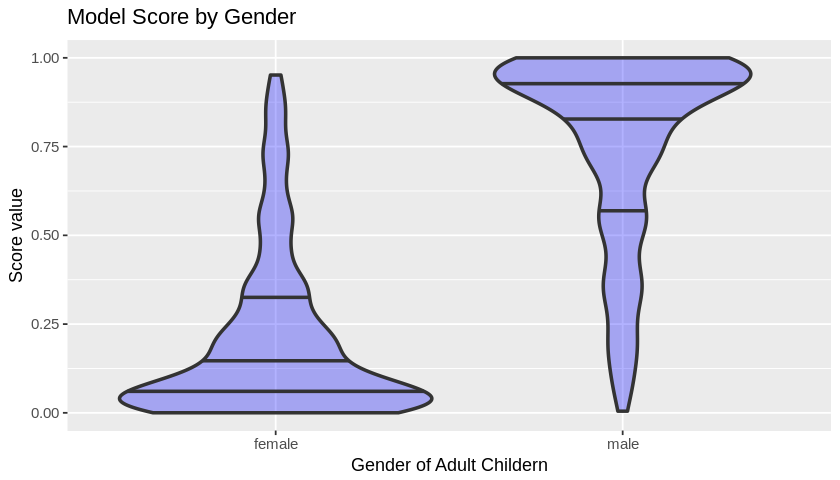

In [13]:
GaltonFamilies2 = GaltonFamilies2 %>% 
                    mutate(score.gender = exp(score)/(1 + exp(score))) 
ggplot(GaltonFamilies2, aes(gender, score.gender)) +
       geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), 
                   fill = 'blue', alpha = 0.3, size = 1.0) +
       ylab('Score value') +
       xlab('Gender of Adult Childern') +
       ggtitle('Model Score by Gender')

In [14]:
GaltonFamilies2 = GaltonFamilies2 %>% 
                    mutate(score.gender = ifelse(score.gender > 0.5, 'male', 'female')) 
glimpse(GaltonFamilies2)
table(GaltonFamilies2$score.gender)

Observations: 934
Variables: 11
$ family            <fctr> 001, 001, 001, 001, 002, 002, 002, 002, 003, 003...
$ father            <dbl> 78.5, 78.5, 78.5, 78.5, 75.5, 75.5, 75.5, 75.5, 7...
$ mother            <dbl> 67.0, 67.0, 67.0, 67.0, 66.5, 66.5, 66.5, 66.5, 6...
$ midparentHeight   <dbl> 75.43, 75.43, 75.43, 75.43, 73.66, 73.66, 73.66, ...
$ children          <int> 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 6, 6...
$ childNum          <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 1, 2, 3, 4, 5, 1, 2...
$ gender            <fctr> male, female, female, female, male, male, female...
$ childHeight       <dbl> 73.2, 69.2, 69.0, 69.0, 73.5, 72.5, 65.5, 65.5, 7...
$ childHeightScaled <dbl> 1.80318959, 0.68563741, 0.62975980, 0.62975980, 1...
$ score             <dbl> 5.1155821, 1.9451279, 1.7866052, 1.7866052, 5.353...
$ score.gender      <chr> "male", "male", "male", "male", "male", "male", "...



female   male 
   476    458 

In [15]:
#library(caret)
confusionMatrix(data = GaltonFamilies2$gender, reference = GaltonFamilies2$score.gender,
               mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction female male
    female    394   59
    male       82  399
                                          
               Accuracy : 0.849           
                 95% CI : (0.8244, 0.8714)
    No Information Rate : 0.5096          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.6982          
 Mcnemar's Test P-Value : 0.06392         
                                          
              Precision : 0.8698          
                 Recall : 0.8277          
                     F1 : 0.8482          
             Prevalence : 0.5096          
         Detection Rate : 0.4218          
   Detection Prevalence : 0.4850          
      Balanced Accuracy : 0.8495          
                                          
       'Positive' Class : female          
                                          

<div style="background-color: ivory;">
<h3>Questions</h3>
<p>Examine these results and answer the following questions:</P>
<ol>
<li>Is the confusion matrix significantly different from the over-fit model?</li>
<li>Is the accuracy significantly different from the over-fit model?</li>
<li>Are precision and recall significantly different from the over-fit model?</li>
</ol>
</div>

### Answers
1. No.

2. No.

3. No.

## Multivariate Classification Example

Now that we have worked through a simple example, with just on feature, let's try a more realistic example with multiple features. For this example, we will use an HR data set from [Kaggle](https://www.kaggle.com/ludobenistant/hr-analytics). Our goal is to classify employees likely to leave the company. The label has two classes, $\{0, 1\}$, for employees who did not or did leave the company. We will use 8 features to train the classifier. 

As a first step, the data needs to be loaded and prepared for analysis. Execute this code and examine the results to get an initial feel for these data. 

***
**Programming note:** The code in the cell below performs the following operations:
1. Read the raw csv file.
2. Use a chain of dplyr verbs to perform the following transformations of the data frame:
  - Convert the salary levels to numeric values, $\{1, 2, 3\}$.
  - Convert the label values to `yes` and `no`.
  - Remove unneeded columns.
3. The label is converted to a categorical variable with the `as.factor` function. 
***

In [16]:
file = 'HR_comma_sep.csv'
hr = read_csv(file, col_names = TRUE)  ## Read the csv file

## Transform some features and remove two which will not be used
hr = hr %>% mutate(salary_numeric = ifelse(salary == 'low', 1, 
                                     ifelse(salary == 'medium', 2, 3)),
                   left = ifelse(left == 1, 'yes', 'no')) %>%
            select(-sales, -salary)
hr$left = as.factor(hr$left)
glimpse(hr)

Parsed with column specification:
cols(
  satisfaction_level = col_double(),
  last_evaluation = col_double(),
  number_project = col_integer(),
  average_montly_hours = col_integer(),
  time_spend_company = col_integer(),
  Work_accident = col_integer(),
  left = col_integer(),
  promotion_last_5years = col_integer(),
  sales = col_character(),
  salary = col_character()
)


Observations: 14,999
Variables: 9
$ satisfaction_level    <dbl> 0.38, 0.80, 0.11, 0.72, 0.37, 0.41, 0.10, 0.9...
$ last_evaluation       <dbl> 0.53, 0.86, 0.88, 0.87, 0.52, 0.50, 0.77, 0.8...
$ number_project        <int> 2, 5, 7, 5, 2, 2, 6, 5, 5, 2, 2, 6, 4, 2, 2, ...
$ average_montly_hours  <int> 157, 262, 272, 223, 159, 153, 247, 259, 224, ...
$ time_spend_company    <int> 3, 6, 4, 5, 3, 3, 4, 5, 5, 3, 3, 4, 5, 3, 3, ...
$ Work_accident         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ left                  <fctr> yes, yes, yes, yes, yes, yes, yes, yes, yes,...
$ promotion_last_5years <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ salary_numeric        <dbl> 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...


### Exploring the data

Before building any machine learning model it is a good idea to explore the data so we get an idea of the structure. We will look at some characteristics of the data and visualize these data. 

We can have a quick look at the number of cases which have each value of the label. The R `table` function computes a count by unique category of a variable. Execute this code and examine the house. 

In [17]:
table(hr$left)


   no   yes 
11428  3571 

We must separate the data frame columns with features from the label so we can explore these data. Execute the code below to create a list of column names for the features.

In [18]:
cols = names(hr)[c(1:6, 8, 9)]
cols

[1] "satisfaction_level"    "last_evaluation"       "number_project"       
[4] "average_montly_hours"  "time_spend_company"    "Work_accident"        
[7] "promotion_last_5years" "salary_numeric"

Next, we will use some **visualization** techniques develop an understanding of the relationship between the label categories and the values of the features. Visualization of these data is a bit tricky. We will try two different types of graphics displays to improve our understanding. 

For our first set of views, we will use **violin** plots. Recall that violin plots show the probability density of a variable on one axis, **conditioned** (grouped-by) the category of another variable on the other axis. In this case, we will use the two categories of the label for the horizontal axis. 

The code in the cell below creates a violin plot for each of the features. Execute this code and examine the results, paying attention to how well, or not, feature separates the label values.  

***
**Programming note:** The function displays a violin plot for the column specified with the `col` argument. Notice the use of `aes_string` which allows the column name to be specified as a string. The `lapply` operator integrates over the list of column names calling the function each time. The last argument of `lapply` fills the second argument of the function. 
***

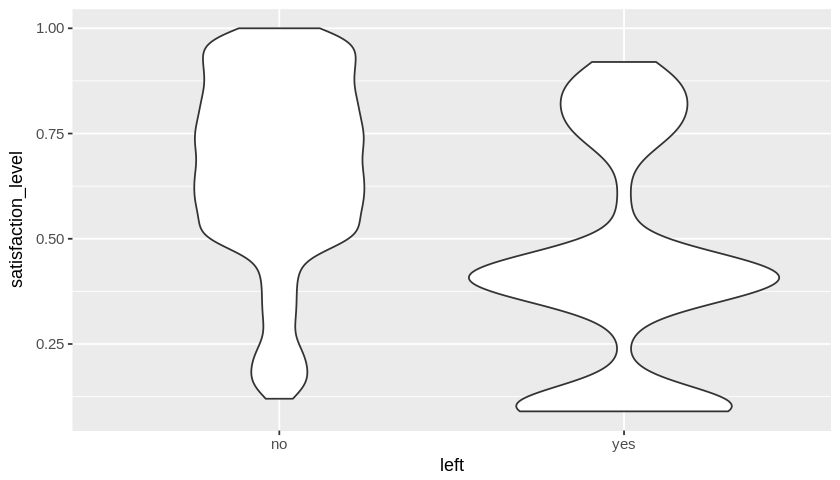

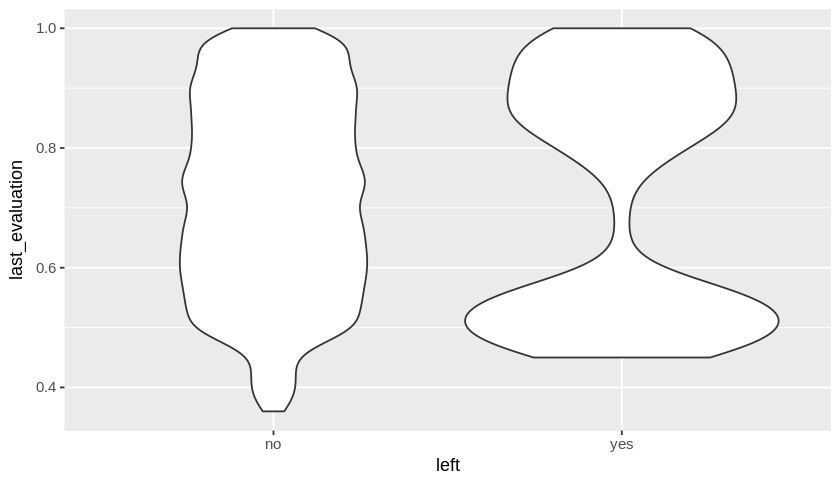

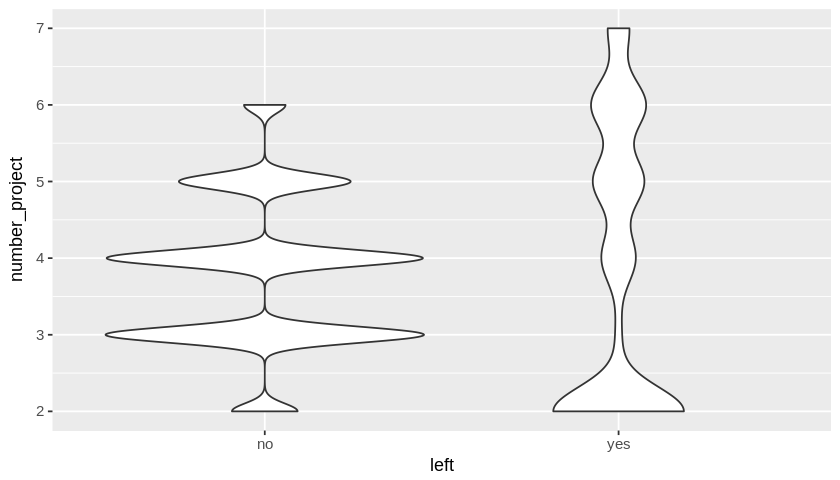

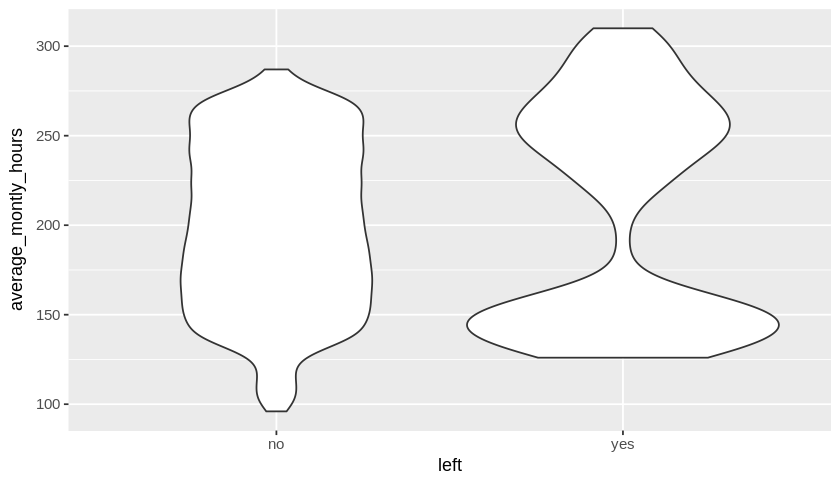

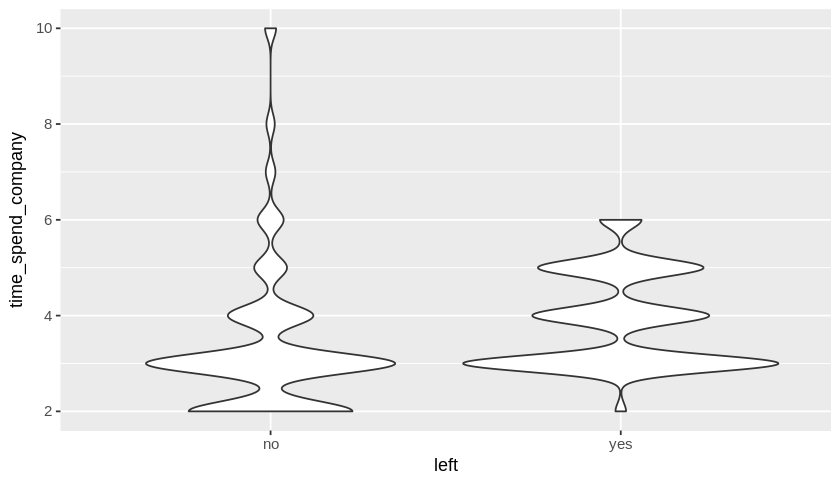

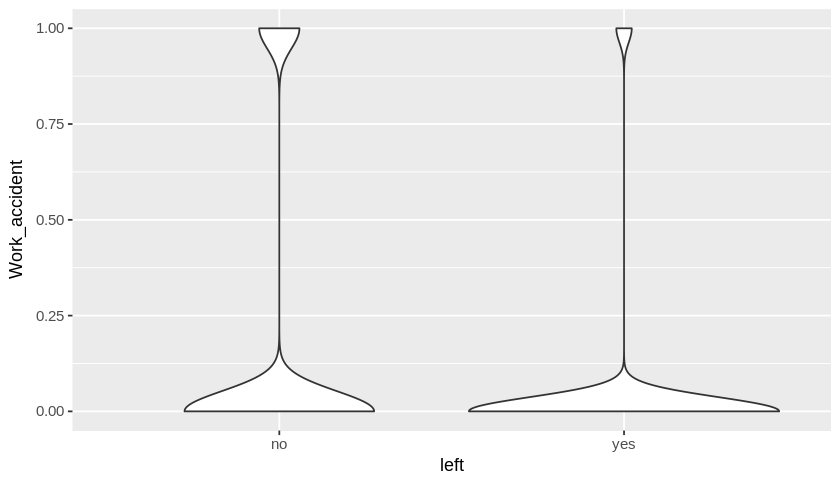

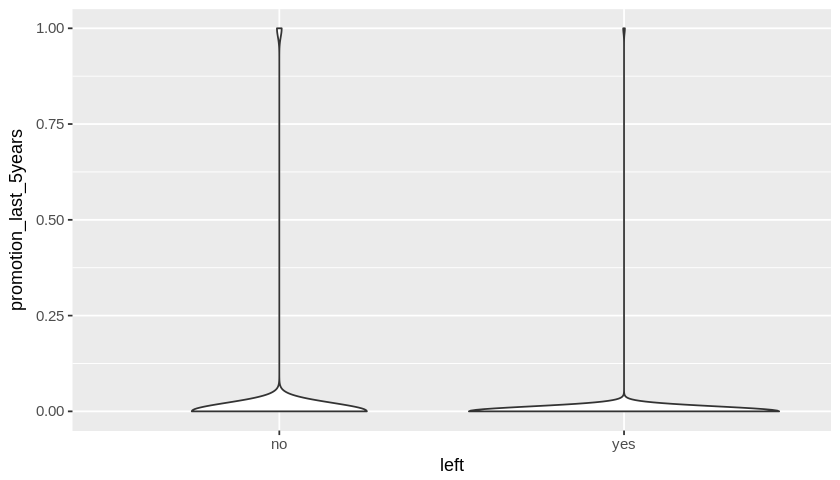

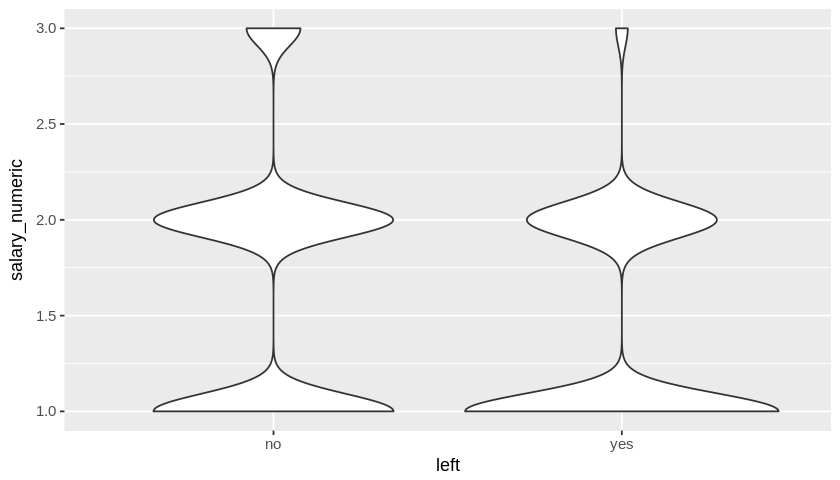

In [19]:
plot.left.v = function(col, df){
    p1 = ggplot(df, aes_string('left', col)) + geom_violin()
    print(p1)
}
invisible(lapply(cols, plot.left.v, hr))

Notice that the relationships between these data and the categories of the label are rather complex.
- Some features have a non-linear relationship with the categories of the label. For example, some features may have multiple interleaved values for each category.
- Some other features do not seem to separate the cases at all. 

### Another view of data

To get a bit more insight into these data, let's create and examine a series of **dot plots**. The dot plots resemble a histogram, but shows the density as a series of stacked dots. The higher the stack, the denser the probability distribution.  

The code in the cell below displays dot plots for each of the features, stratified by the label categories. The structure of this code is nearly identical to the code used for the violin plots. Execute this code and examine the results for each feature. 

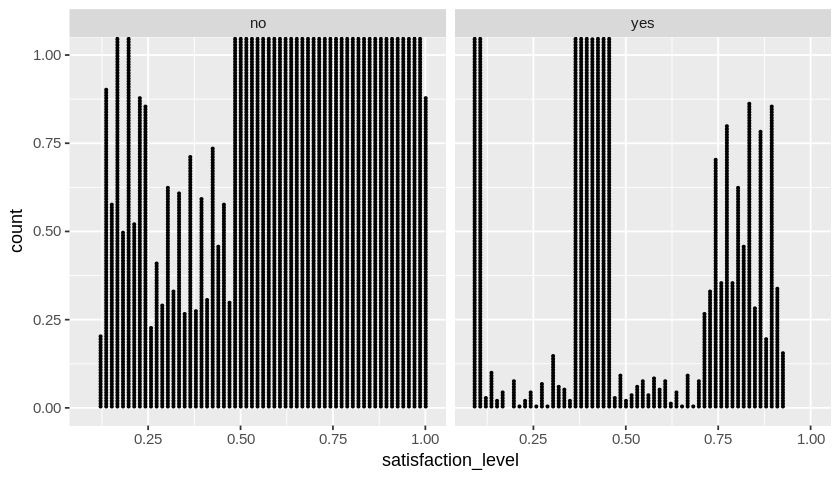

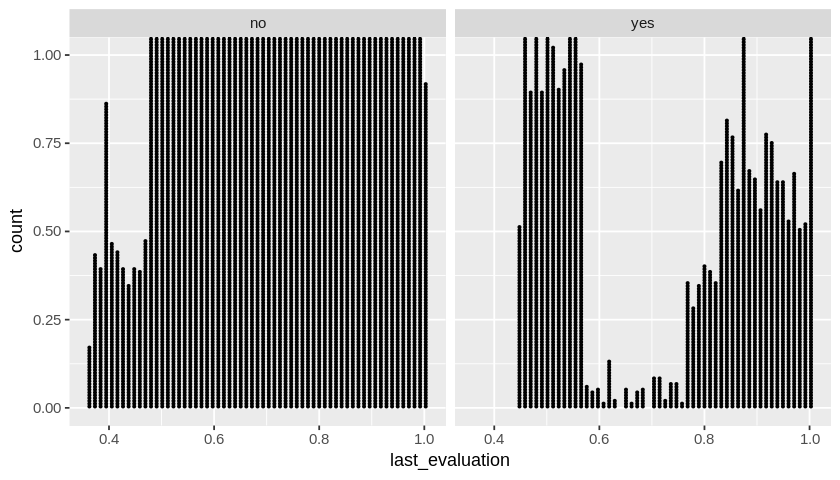

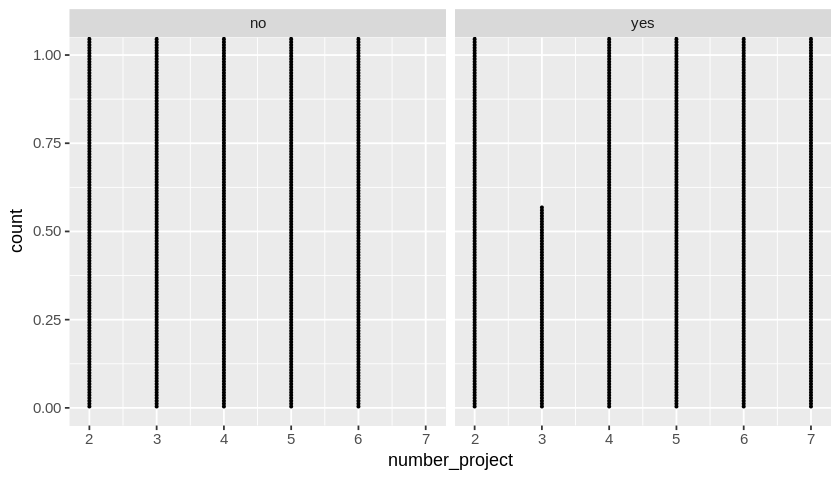

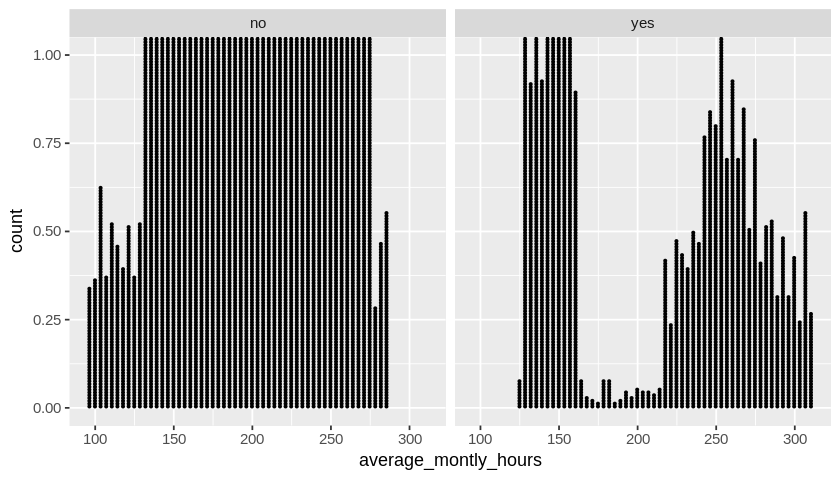

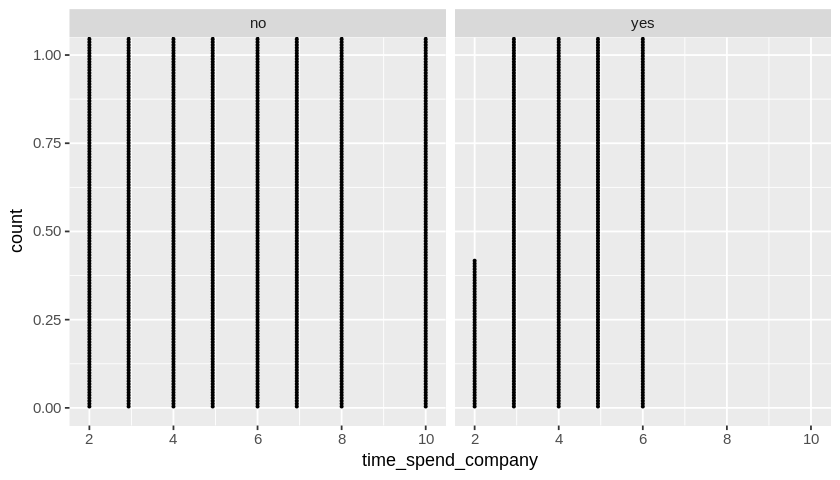

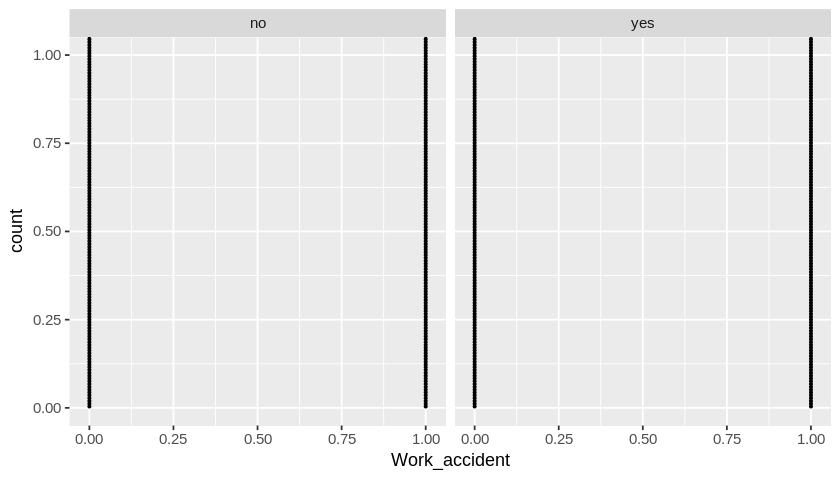

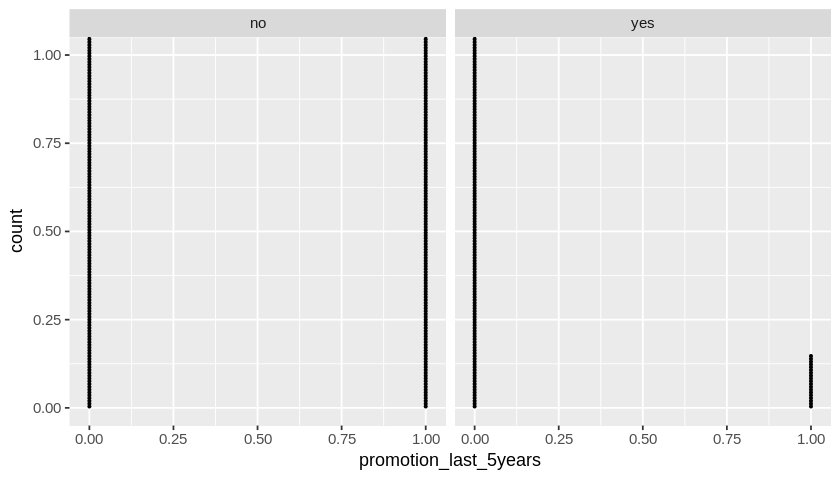

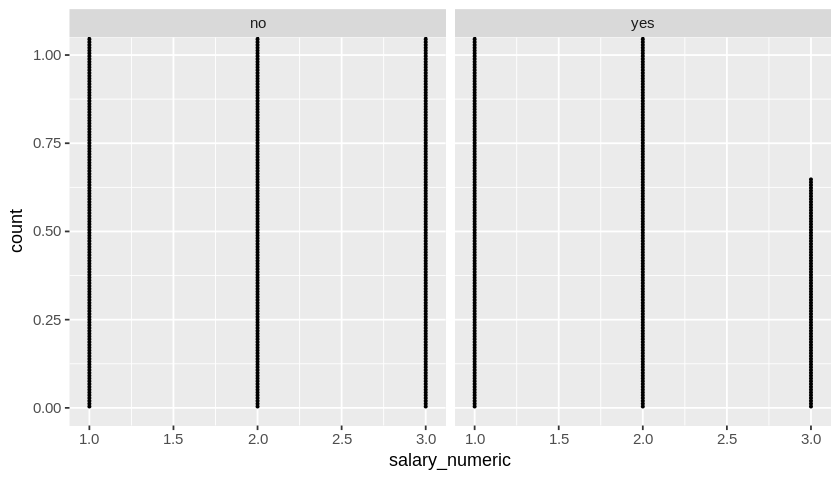

In [20]:
plot.left = function(col, df, bins = 60){
    binwidth = (max(df[, col]) - min(df[, col])) / bins
    p1 = ggplot(df, aes_string(col)) + 
           geom_dotplot(dotsize = 0.5, method = "histodot", binwidth = binwidth) +
           facet_grid(. ~ left)
    print(p1)
}
#plot.left('last_evaluation', hr)
invisible(lapply(cols, plot.left, hr))

Carefully examine these plots and compare them to the violin plots. While the dot plots show more detail, the overall conclusion are roughly the same, with one possible exception:

1. The values of the feature have a nonlinear relationship to the categories of the label. In several cases, there are alternating segments of the values of the feature stratified by the label categories.
2. In several cases, the values at the end of the range for a feature are different for different label categories. This relationship was not as obvious with the violin plots.
3. The values for at least one feature are nearly the same when stratified by the label categories.

These complex relationships between the feature values and label category will make it difficult for our linear classifier to separate the cases. None the less, we will press on. 

### Train the classifier

We have seen that the relationship between the features and the categories in the labels. It is clear that a linear classifier will not be the ideal tool. However, for the purpose of this lesson, we will use logistic regression.  

The first step in constructing our machine learning model is to prepare the data. These data are fairly clean, so we only need to preform two steps:

1. Ensure there are no duplicated cases in the data set. Duplicated cases can bias the training of the model. Further, duplicated cases confound the splitting of the data into training and test data sets. 
2. normalize the numeric features. The code in the cell below iterates over the features in the data frame and apply the normalize functions. 

Execute the code. 

In [21]:
hr = hr[!duplicated(hr), ]
nrow(hr)

hr[, cols] = lapply(hr[, cols], normalize) 

[1] 11959

We need to test the model we train in an unbiased manner. If we test the performance of any machine learning model with the same data used to train it, we would likely see **unrealistically optimistic** results. You can imagine a case where the machine learning model is severely overfit (for example a **saturated model**), and has learned the data perfectly. Such a model would produce excellent test results when presented with these same training data. However, it is unlikely that such a model would **generalize** and work well new input cases. If tested with data not in the training set, the performance of such a model will be poor. 

To avoid the aforementioned problems, we must split our data set into two **mutually exclusive** subsets. We call these subsets the **training data set** and the **test data set**. The code in the cell below performs the following steps.
1. The dplyr `sample_frac` verb is used to create a randomly sampled training data set.
2. The R `setdiff` function is used to filter for cases (rows) of the original data not in the training data set. This is our test data set.
3. The number of rows in the two subsets are verified. 

Execute this code and verify the results. 

In [22]:
hr.train = sample_frac(hr, 0.7)
hr.test = setdiff(hr, hr.train)
nrow(hr.train)
nrow(hr.test)
nrow(hr.test) + nrow(hr.train) == nrow(hr)

[1] 8371

[1] 3588

[1] TRUE

With this minimal preparation to the data, we are ready to train the **generalized linear model (glm)** classifier. The R `glm` function implements a generalization of linear regression. In this particular case we use three arguments to this function as follows:

1. **Model formula:** We use the R formula language to specify that all features are used to model the label, `left`, as follows:
$$left\ \sim\ .\\
where\\
. = symbolizes\ other\ columns
$$
2. **Data set:** We are using the training data set which represents 70% of the original data.
3. **Family:** The family is the distribution family for the label. In this case, we specify the **binomial** function since we have a two-class classifier. 

Execute the code in the cell below and examine the model summary and the confidence interval of the coefficients.

In [23]:
hr.mod1 = glm(left ~ ., data = hr.train, family=binomial())
summary(hr.mod1)
cat('Confidence intervals of model coefficients')
confint(hr.mod1)


Call:
glm(formula = left ~ ., family = binomial(), data = hr.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0126  -0.5462  -0.3576  -0.1997   3.2069  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -2.16401    0.04322 -50.075  < 2e-16 ***
satisfaction_level    -0.97525    0.03539 -27.556  < 2e-16 ***
last_evaluation        0.12607    0.03675   3.430 0.000603 ***
number_project        -0.32968    0.03681  -8.957  < 2e-16 ***
average_montly_hours   0.20096    0.03656   5.497 3.85e-08 ***
time_spend_company     0.38187    0.03180  12.010  < 2e-16 ***
Work_accident         -0.55434    0.04967 -11.160  < 2e-16 ***
promotion_last_5years -0.17337    0.05790  -2.994 0.002753 ** 
salary_numeric        -0.40119    0.03676 -10.915  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7313.1  on 8370  degrees of

Confidence intervals of model coefficients

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-2.24995648,-2.0805110
satisfaction_level,-1.04517916,-0.9064213
last_evaluation,0.05412071,0.1982191
number_project,-0.40216395,-0.2578523
average_montly_hours,0.12946740,0.2727902
time_spend_company,0.31939956,0.4440927
Work_accident,-0.65471030,-0.4597297
promotion_last_5years,-0.30069637,-0.0702405
salary_numeric,-0.47378500,-0.3296740


This model appears to be a reasonable fit. When examining these results, notice the following:

- The standard errors of all coefficients is significantly are all at least an order of magnitude smaller than the coefficient values themselves.
- The z-values are all reasonably large, leading to small p-value indicating the coefficients are significant. 
- There is a is a notable difference between the Null deviance and the Residual deviance, along with a reasonable value of AIC, indicating that the model is explaining some variation in the data. 
- None of the confidence intervals of the coefficients overlaps zero.

### Scoring the model

With the  model trained, we will now score the model. The coded in the cell below does the following:
1. The raw model score is computed from the trained model using the `predict` method. Notice that **the test data set** is now being used. 
2. A dot plot is made of the raw scores stratified by the (known) label categories. 

Execute this code and examine the results. 

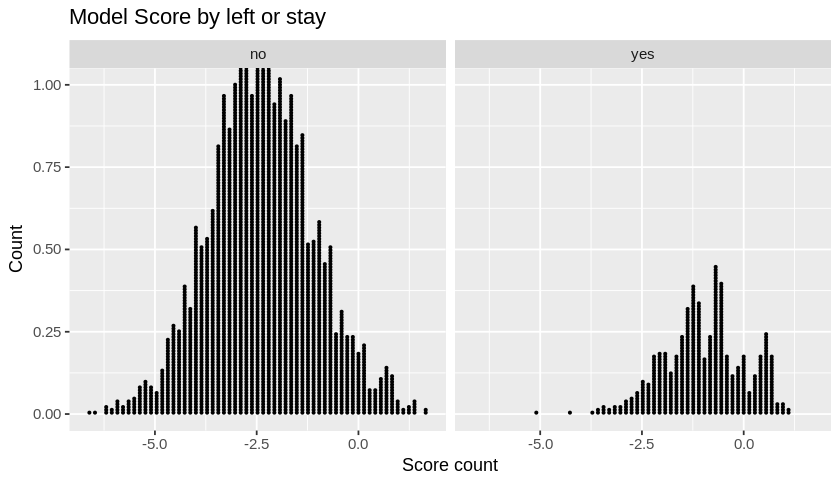

In [24]:
hr.test$score = predict(hr.mod1, newdata = hr.test)

binwidth = (max(hr.test[, 'score']) - min(hr.test[, 'score'])) / 60
ggplot(hr.test, aes(x = score)) + 
       geom_dotplot(dotsize = 0.5, method = "histodot", binwidth = binwidth) +
       facet_grid(. ~ left) +
       ylab('Count') +
       xlab('Score count') +
       ggtitle('Model Score by left or stay')

Examine the distribution of scores for both label categories. The values for the `yes` category are shifted to the right. However, there is considerable overlap between values for `yes` and `no`. This is not surprising, given the complex relationship between the features and the label categories. 

Now, we need to transform these scores into categories. The first step in doing so is to apply a **logistic function** to the numeric scores. In technical terms, this operation transforms the **Binomial** regression to a logistic regression. Execute the code in the cell below to apply the transformation and display the result. 

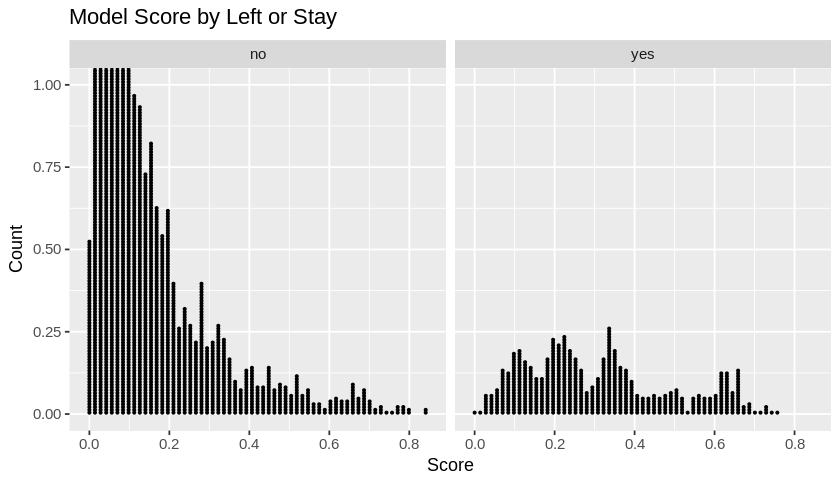

In [25]:
hr.test = hr.test %>% mutate(score = exp(score)/(1 + exp(score)))

binwidth = (max(hr.test[, 'score']) - min(hr.test[, 'score'])) / 60
ggplot(hr.test, aes(x = score)) + 
       geom_dotplot(dotsize = 0.5, method = "histodot", binwidth = binwidth) +
       facet_grid(. ~ left) +
       ylab('Count') +
       xlab('Score') +
       ggtitle('Model Score by Left or Stay')

You can see that the transformed score is the now in the range $\{ 0, 1 \}$. Further, the transformed scores for `yes` are skew to the right with respect to the `no` scores, and with considerable overlap. 

There is one last step to finish the classification. We need to convert the score to the category values. We will set the categories based on values greater than or less than and equal to a **threshold** setting the value to `yes` or `no`. 

The code in the cell below sets the threshold at $0.5$. Execute the code and examine the results.

In [26]:
hr.test$score.pred = ifelse(hr.test$score > 0.5, 'yes', 'no')
glimpse(hr.test)

Observations: 3,588
Variables: 11
$ satisfaction_level    <dbl> -2.1602177, 0.8704462, 1.0780260, 0.7874143, ...
$ last_evaluation       <dbl> 0.9687903, 1.2065445, 1.2065445, 0.9093517, -...
$ number_project        <dbl> 2.7530434, 0.1679581, 1.0296532, 0.1679581, -...
$ average_montly_hours  <dbl> 1.4677254, 0.6872123, 0.8515308, 0.7899114, -...
$ time_spend_company    <dbl> 0.4766481, 1.2275683, 1.2275683, 1.2275683, -...
$ Work_accident         <dbl> -0.4277732, -0.4277732, -0.4277732, -0.427773...
$ left                  <fctr> yes, yes, yes, yes, yes, yes, yes, yes, yes,...
$ promotion_last_5years <dbl> -0.1314014, -0.1314014, -0.1314014, -0.131401...
$ salary_numeric        <dbl> 0.6215039, -0.9505277, -0.9505277, -0.9505277...
$ score                 <dbl> 0.41212627, 0.15868608, 0.10702103, 0.1674387...
$ score.pred            <chr> "no", "no", "no", "no", "no", "no", "no", "no...


### Evaluating the classifier  

Now that we have trained the model, computed scores, and performed classification based on a threshold value, we can evaluate the performance of the classifier. The code in the cell below computes and prints the confusion matrix and other performance metrics using the test data. Execute this code and examine the results.

In [27]:
confusionMatrix(data = hr.test$left, reference = hr.test$score.pred, mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2838  115
       yes  520  115
                                          
               Accuracy : 0.823           
                 95% CI : (0.8101, 0.8354)
    No Information Rate : 0.9359          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1896          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.9611          
                 Recall : 0.8451          
                     F1 : 0.8994          
             Prevalence : 0.9359          
         Detection Rate : 0.7910          
   Detection Prevalence : 0.8230          
      Balanced Accuracy : 0.6726          
                                          
       'Positive' Class : no              
                                          

Notice the following about these results:
- The overall accuracy is about 83%. On the face of it, this would appear to be a good result.
- The confusion matrix tells another story. about 5 out of 6 yes cases are misclassified. Most of the no cases are correctly classified. This imbalance between errors in classifying the yes cases and the majority no explains the high accuracy figure.
- The precision is significantly larger than the recall, which is a result of the imbalance in accuracy between the `no` and `yes` cases. 
- As expected, the F1 score is between the precision and the recall. 

***
# <font color="blue">Your turn</font>   

In the foregoing example, a threshold of 0.5, which gives equal weight to each class. This threshold setting produced poor classification of the `yes` cases. As mentioned before, from the point of view of the company, this classifier will be of limited use in identifying employees likely to leave.  

You can adjust the trade-off between errors in the two label categories by changing the threshold. In this exercise you will try the following threshold values, $\{ 0.45, 0.40, 0.35, 0.30, 0.25 \}$. 

**Hint:** Write a function that computes the score, $$, for each of these threshold values and prints the confusion matrix. You can then use the `lapply` operator to iterate over the list of threshold values. 
***

In [28]:
# including threshold = 0.5 for verification with previous code block
thrs = c(0.5, 0.45, 0.40, 0.35, 0.30, 0.25)
compute_score <- function(thr, df) {
    df$score.pred = ifelse(df$score > thr, 'yes', 'no')
    ccmm <- confusionMatrix(data = df$left, reference = df$score.pred, mode = "prec_recall")
    print(c("threshold =", thr))
    print(ccmm)
    print("*********************************")
}

invisible(lapply(thrs, compute_score, hr.test))

[1] "threshold =" "0.5"        
Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2838  115
       yes  520  115
                                          
               Accuracy : 0.823           
                 95% CI : (0.8101, 0.8354)
    No Information Rate : 0.9359          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1896          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.9611          
                 Recall : 0.8451          
                     F1 : 0.8994          
             Prevalence : 0.9359          
         Detection Rate : 0.7910          
   Detection Prevalence : 0.8230          
      Balanced Accuracy : 0.6726          
                                          
       'Positive' Class : no              
                                          
[1] "******************************

In [29]:
# test various thresholds with yes assigned to positive 
# including threshold = 0.5 for verification with previous code blocks
thrs = c(0.5, 0.45, 0.40, 0.35, 0.30, 0.25)
compute_score <- function(thr, df) {
    df$score.pred = ifelse(df$score > thr, 'yes', 'no')
    ccmm <- confusionMatrix(data = df$left, reference = df$score.pred, mode = "prec_recall", positive = "yes")
    print(c("threshold =", thr))
    print(ccmm)
    print("*********************************")
}

invisible(lapply(thrs, compute_score, hr.test))

[1] "threshold =" "0.5"        
Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2838  115
       yes  520  115
                                          
               Accuracy : 0.823           
                 95% CI : (0.8101, 0.8354)
    No Information Rate : 0.9359          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1896          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.18110         
                 Recall : 0.50000         
                     F1 : 0.26590         
             Prevalence : 0.06410         
         Detection Rate : 0.03205         
   Detection Prevalence : 0.17698         
      Balanced Accuracy : 0.67257         
                                          
       'Positive' Class : yes             
                                          
[1] "******************************

<div style="background-color: ivory">
<h3>Questions</h3>
<p>Examine these results and answer these questions:</p>
<ol>
<li>As the threshold value decreases does the fraction of the correctly classified yes cases increase or decrease?</li>
<li>As the threshold value decreases does the fraction of incorrectly classified no cases increase or decrease?</li>
<li>How does the accuracy change, increase, decrease, or stay about the same?</li>
<li>How do the precision and recall change as the threshold decreases, precision increases and recall decreases, precision decreases and recall increases, precision and recall remain about the same? </li>
<li>Will the classifier with a smaller threshold be more useful to the company assuming the cost of an employee leaving is greater than the cost of incorrectly classifying an employee who is not leaving as one who might. </li>
</ol>
</div>


### Answers
1. As the threshold value decreases, fraction of correctly classified yes cases (Precision for yes) increases.

2. As the threshold value decreases, fraction of incorrectly classified no cases (1-Precsion for no) increases.

3. As the threshold value decreases, accuracy decreases slightly/stay about the same (0.82 to 0.79).

4. 'Positive' Class = no: as the threshold decreases, precision decreases and recall increases. (For 'Positive' Class = yes: precision increases and recall decreases).

5. Interpretation: the goal is to identify employees who are leaving; false positives are less costly than false negatives; maximize recall at the expense of precision for 'Positive Class = yes. 
In this case a smaller threshold will not be more useful because as threshold decreases, precision for yes increases and recall for yes decreases.

## Summary

In this lesson you have done the following:

- Explored the basics of classifier models using logistic regression as an example.
- Train a simple classifier using a single feature.
- Evaluation the classifier model using the two-class classification example.
- Construct and evaluate a multivariate (multiple feature) classifier for a real-world example.
